# COVID-19 Prediction using Transfer Learning

I'll be using transfer learning on a pre-trained CNN to build an COVID-19/Normal classifier!

<img src="TransferLearning.png" style="width:700px;height:300px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

## Table of Content

- [1 - Import Packages](#5)
- [2 - Data Preprocessing](#2)
    - [2.1 - Create the Dataset and Split it into Training and Validation Sets](#ex-1)
    - [2.1 - Test Data set](#)
- [3 - Preprocess and Augment Training Data](#3)
    - [3.1 - Data Augmentation](#3-1)
    - [3.2 - Rescale Pixel Values](#3-2)
- [4 - Creating the base model from the pre-trained Convnets](#3-3)
    - [4.1 - Inside a MobileNetV2 Convolutional Building Block](#3-3)
    - [4.2 - Layer Freezing with the Functional API](#)
    - [4.3 - Model Function](#)
- [5 - Compile the model](#3-3)
    - [5.1 - Train the model](#3-3)
    - [5.2 Learning Curve](#ex-3)
- [6 - Fine Tuning](#)
    - [6.1 - Compile the model](#3-3)
    - [6.1 - Continure Training the Model](#3-3)
        - [Learning Curve](#ex-3)
- [7 - Evaluation and Prediction](#)

<font color='blue'>
    
## 1. Importing Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<font color='blue'>

## 2. Data Preprocessing

### 2.1 Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If we are specifying a validation split, we will also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

We will also set our seeds to match each other, so our training and validation sets don't overlap. :)

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

Found 13808 files belonging to 2 classes.
Using 11047 files for training.


In [3]:
class_names = train_dataset.class_names
print(class_names)

['COVID', 'Normal']


In [4]:
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 13808 files belonging to 2 classes.
Using 2761 files for validation.


In [5]:
class_names = validation_dataset.class_names
print(class_names)

['COVID', 'Normal']


Now let's take a look at some of the images from the training set.

    First nine images and labels from the training set:

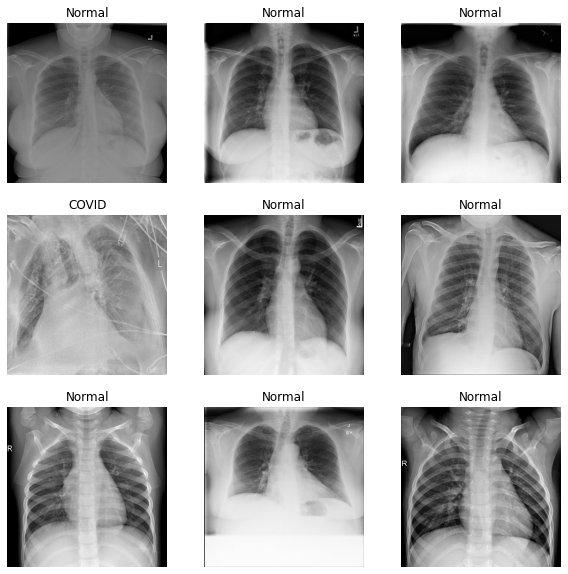

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### 2.2 Test Data set 
As the original dataset doesn't contain a test set, we will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 70
Number of test batches: 17


<font color='blue'>

## 3. Preprocess and Augment Training Data

`dataset.prefetch` is an important extra step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from our input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

We can set the number of elements to prefetch manually, or we can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### 3.1 Data Augmentation

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later. 

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). More details about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

Official documents for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
def data_augmenter():
    '''
    Creating a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    
    return data_augmentation

In [11]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


Let's repeatedly apply these layers to the same image and see the result.

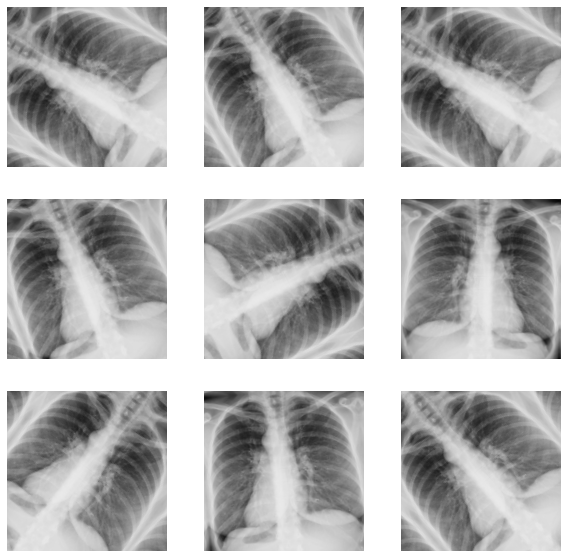

In [12]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### 3.2 Rescale Pixel Values

In a moment, we will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in our images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<font color='blue'>

## 4. Creating the base model from the pre-trained Convnets

We will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we need to pick which layer of MobileNet V2 we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

<font color='red'>

### Recheck the documentation from here

### 4.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="mobilenet.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

**Note:** The last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [16]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Notice some of the layers in the summary like `Conv2D` and `DepthwiseConv2D` and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck layers mentioned earlier.

<font color='DarkViolet'>

**Important Point**:

* MobileNetV2's unique features are: 
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


#### Not Important just for validation of our model

In [18]:
# Not so Important just for validation of our model
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [19]:
# Not Important just for validation of our model
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.46961927),
  ('n04209239', 'shower_curtain', 0.035068307)],
 [('n04589890', 'window_screen', 0.3814481),
  ('n03887697', 'paper_towel', 0.044693362)],
 [('n02895154', 'breastplate', 0.14506145),
  ('n03146219', 'cuirass', 0.1282813)],
 [('n04589890', 'window_screen', 0.9405104),
  ('n04209239', 'shower_curtain', 0.0071919844)],
 [('n03709823', 'mailbag', 0.20905846), ('n02730930', 'apron', 0.14989766)],
 [('n04589890', 'window_screen', 0.6488204),
  ('n04209239', 'shower_curtain', 0.030711712)],
 [('n04589890', 'window_screen', 0.580133),
  ('n03347037', 'fire_screen', 0.2434304)],
 [('n04589890', 'window_screen', 0.8010383),
  ('n04590129', 'window_shade', 0.017107096)],
 [('n04589890', 'window_screen', 0.26441127),
  ('n03709823', 'mailbag', 0.06513967)],
 [('n04589890', 'window_screen', 0.1591502),
  ('n02098286', 'West_Highland_white_terrier', 0.05196282)],
 [('n04589890', 'window_screen', 0.6243037),
  ('n04209239', 'shower_curtain', 0.040302157)

Extra Knowledge:

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.



### 4.2 Layer Freezing with the Functional API

We will see how we can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

### 4.3 Model

In [20]:
def COVID_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = image_shape + (3,),
                                                   include_top = False, # <== Important!!!!
                                                   weights = 'imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape = input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training = False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(1)
    
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

Creating our new model using the data_augmentation function defined earlier.

In [21]:
model2 = COVID_model(IMG_SIZE, data_augmentation)

In [22]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

#### Just for validating (not so important)

In [23]:
from test_utils import summary, comparator

COVID_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TFOpLambda', (None, 160, 160, 3), 0],
                    ['TFOpLambda', (None, 160, 160, 3), 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), COVID_summary)

All tests passed!



<font color='blue'>

## 5. Compile the Model

In [24]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\bhart\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
len(model2.trainable_variables)

2

### 5.1 Train the Model

In [26]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
346/346 [==============================] - 219s 626ms/step - loss: 0.3284 - accuracy: 0.8651 - val_loss: 0.9798 - val_accuracy: 0.5593
Epoch 2/5
346/346 [==============================] - 220s 636ms/step - loss: 0.3226 - accuracy: 0.8823 - val_loss: 0.4337 - val_accuracy: 0.7889
Epoch 3/5
346/346 [==============================] - 241s 695ms/step - loss: 0.3123 - accuracy: 0.8885 - val_loss: 0.5428 - val_accuracy: 0.7799
Epoch 4/5
346/346 [==============================] - 239s 689ms/step - loss: 0.3066 - accuracy: 0.8936 - val_loss: 0.6125 - val_accuracy: 0.7077
Epoch 5/5
346/346 [==============================] - 258s 744ms/step - loss: 0.2976 - accuracy: 0.8905 - val_loss: 0.3441 - val_accuracy: 0.8692


### 5.2 Learning curves

Plot the training and validation accuracy:

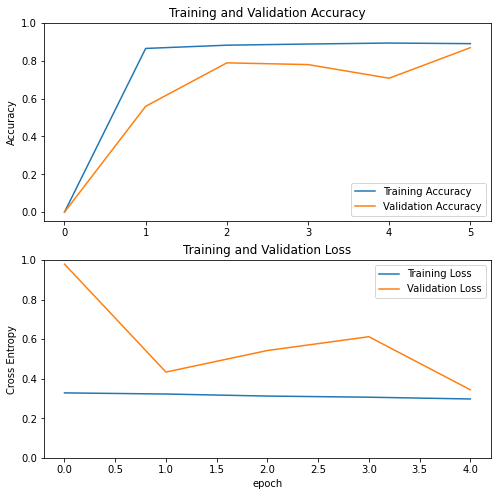

In [27]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
class_names

['COVID', 'Normal']

The results are ok, but could be better, now let's go for fine-tuning

<font color='blue'>

## 6. Fine Tuning



We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if our accuracy improved!

### Un-freeze the top layers of the model

All we need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, we should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  156


In [31]:
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits = True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

### 6.1 Compile the model

In [32]:
model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [33]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

All tests passed!


In [34]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [35]:
len(model2.trainable_variables)

2

### 6.2 Continue Training the Model

This will improve our accuracy by a few percentage points.

In [36]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
346/346 [==============================] - 339s 969ms/step - loss: 0.2460 - accuracy: 0.9054 - val_loss: 0.4497 - val_accuracy: 0.7866
Epoch 6/10
346/346 [==============================] - 247s 709ms/step - loss: 0.2307 - accuracy: 0.9090 - val_loss: 0.3245 - val_accuracy: 0.8457
Epoch 7/10
346/346 [==============================] - 232s 669ms/step - loss: 0.2370 - accuracy: 0.9088 - val_loss: 0.3377 - val_accuracy: 0.8304
Epoch 8/10
346/346 [==============================] - 239s 690ms/step - loss: 0.2241 - accuracy: 0.9105 - val_loss: 0.3506 - val_accuracy: 0.8281
Epoch 9/10
346/346 [==============================] - 242s 695ms/step - loss: 0.2167 - accuracy: 0.9139 - val_loss: 0.3640 - val_accuracy: 0.8137
Epoch 10/10
346/346 [==============================] - 201s 579ms/step - loss: 0.2151 - accuracy: 0.9148 - val_loss: 0.2891 - val_accuracy: 0.8624


Learning Curve

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

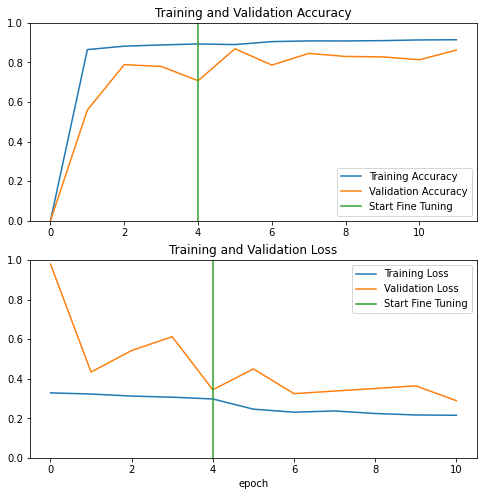

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

## 7. Evaluation and prediction

Finaly we can verify the performance of the model on new data using test set.

In [41]:
loss, accuracy = model2.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 8s 430ms/step - loss: 0.3104 - accuracy: 0.8419
Test accuracy : 0.841911792755127


And now we are all set to use this model to predict COVID-19.

Predictions:
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
Labels:
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


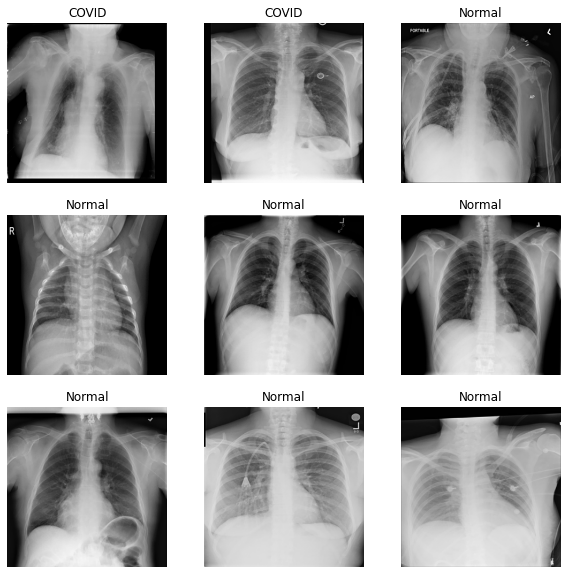

In [42]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [43]:
import tensorflow as tf

from keras.models import load_model

model2.save('COVID19_MobileNetV2.h5')

C:\Users\bhart\Anaconda\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Extra 

In [44]:
model2.evaluate(train_dataset)

346/346 [==============================] - 180s 518ms/step - loss: 0.2641 - accuracy: 0.8654


[0.2640923261642456, 0.865393340587616]

In [45]:
model2.evaluate(validation_dataset)

70/70 [==============================] - 31s 433ms/step - loss: 0.2960 - accuracy: 0.8602


[0.29603102803230286, 0.860171377658844]

## Test Image

In [46]:
model = load_model('COVID19_MobileNetV2.h5')

In [60]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [70]:
predictions = model.predict(validation_dataset)

In [77]:
import seaborn as sns
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 

In [85]:
# y_pred =np.argmax(predictions, axis=-1)
# y_pred = [1 * (x[0]>=0.5) for x in predictions]
# cf_matrix =confusion_matrix(validation_dataset.classes,y_pred)

# group_names = ["True Pos","False Pos","False Neg","True Neg"]
# group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

# labels = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
# labels =np.asarray(labels).reshape(2,2)

# categories = ["COVID-19","Normal"]
# sns.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=categories, yticklabels=categories, cmap='Blues')

## Done! 

<font color='DarkViolet'>

**Important Points**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 